## **Part A**
### • DOMAIN: Botanical Research
### • CONTEXT: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at various stages of growth. They already have have invested on curating sample images. They require an automation which can create a classifier capable of determining a plant's species from a photo.
### • DATA DESCRIPTION: The dataset comprises of images from 12 plant species. Source: https://www.kaggle.com/c/plant-seedlings-classification/data.
### • PROJECT OBJECTIVE: To create a classifier capable of determining a plant's species from a photo.
### Steps and tasks:
1.Import and Understand the data

A. Extract ‘plant-seedlings-classification.zip’ into new folder (unzipped) using python.

In [2]:
import pandas as pd
import numpy as np
import os
import zipfile


In [3]:
!unzip -u "/content/drive/MyDrive/AIML/plant-seedlings-classification.zip" -d "/content/drive/MyDrive/AIML/Unzipped"


Archive:  /content/drive/MyDrive/AIML/plant-seedlings-classification.zip


B. Map the images from train folder with train labels to form a DataFrame.

In [4]:
import cv2
from glob import glob
import tensorflow as tf

In [5]:
images_path = "/content/drive/MyDrive/AIML/Unzipped/plant-seedlings-classification/train"

from glob import glob
image_list = []
class_list=[]
missing=0

for class_folder_name in os.listdir(images_path):
    class_folder_path = os.path.join(images_path, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_rs = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_rs is None: # if the file contain any missing value ignore it
          missing += 1
          continue

         
        image_list.append(image_rs)
        class_list.append(class_label)

In [6]:
def resized_images(img):

  img = np.array(img).astype(np.uint8)
  res = cv2.resize(img,(128,128), interpolation = cv2.INTER_CUBIC) #keeping image size 128*128 as the notebook is crashing on 256*256 due to memory issues
  return res

images = [resized_images(img) for img in image_list]

In [7]:
images[0].shape

(128, 128, 3)

In [8]:
image_list = np.array(images)
class_list = np.array(class_list)
print("images shape: ", image_list.shape)
print("classes shape: ", class_list.shape)


images shape:  (4750, 128, 128, 3)
classes shape:  (4750,)


In [9]:
df = pd.DataFrame({'Label':class_list})

In [10]:
df['Label'].value_counts()


Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

In [11]:
print(image_list.shape)


(4750, 128, 128, 3)


C. Write a function that will select n random images and display images along with its species



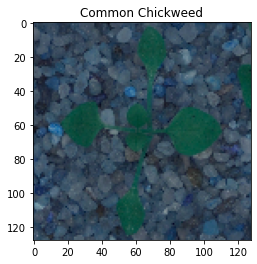

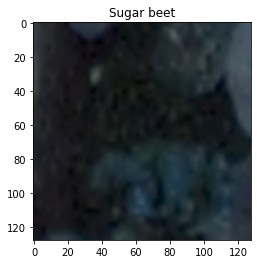

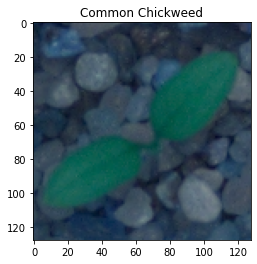

In [12]:
import random 
import matplotlib.pyplot as plt

images = image_list
labels = np.array(df['Label'])

def select_random_images(num_images):

  random_indices = random.sample(range(len(images)), num_images)
  
  selected_labels = [labels[i] for i in random_indices]
  
  for i in range(num_images):
    plt.imshow(images[random_indices[i]])
    plt.title(selected_labels[i])
    plt.show()

select_random_images(3)

2. Data preprocessing

A. Create X & Y from the DataFrame.

In [13]:
X = image_list
y = df['Label']

B. Encode labels of the images



In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y= le.fit_transform(y)

In [15]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [16]:
y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

C. Unify shape of all the images



In [17]:
X.shape[0]


4750

D. Normalise all the images.



In [18]:
X = X.astype('float32')
X = X.reshape(X.shape[0],128,128,3)
X = X / 255.


## Model training
A. Split the data into train and test data

In [19]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 1)

B. Create new CNN architecture to train the model.



In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D

model1 = Sequential()
model1.add(BatchNormalization(input_shape = (128,128,3)))
model1.add(Convolution2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = (128,128,3)))
model1.add(MaxPooling2D(pool_size = 2))

model1.add(Convolution2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D(pool_size = 2))

model1.add(Convolution2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D(pool_size = 3))

model1.add(Convolution2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D(pool_size = 2))

model1.add(Flatten())

model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(16, activation = 'relu'))
model1.add(Dense(8, activation = 'relu'))

model1.add(Dense(12, activation = 'softmax'))

model1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                        

C. Train the model on train data and validate on test data.



In [21]:
history = model1.fit(X_train,y_train, epochs = 30, validation_data = (X_test, y_test), batch_size = 8)


Epoch 1/30
416/416 [==============================] - 17s 12ms/step - loss: 2.4533 - accuracy: 0.1395 - val_loss: 2.4315 - val_accuracy: 0.1740
Epoch 2/30
416/416 [==============================] - 5s 11ms/step - loss: 2.2098 - accuracy: 0.2259 - val_loss: 1.8630 - val_accuracy: 0.3095
Epoch 3/30
416/416 [==============================] - 4s 10ms/step - loss: 1.6643 - accuracy: 0.4289 - val_loss: 1.3343 - val_accuracy: 0.5691
Epoch 4/30
416/416 [==============================] - 4s 10ms/step - loss: 1.2141 - accuracy: 0.5844 - val_loss: 0.9858 - val_accuracy: 0.6730
Epoch 5/30
416/416 [==============================] - 5s 11ms/step - loss: 0.9834 - accuracy: 0.6740 - val_loss: 0.8558 - val_accuracy: 0.7144
Epoch 6/30
416/416 [==============================] - 4s 10ms/step - loss: 0.8280 - accuracy: 0.7320 - val_loss: 0.7898 - val_accuracy: 0.7432
Epoch 7/30
416/416 [==============================] - 5s 12ms/step - loss: 0.6961 - accuracy: 0.7636 - val_loss: 0.8352 - val_accuracy: 0.735

The model is an overfit and did not converge properly. Using data augmentation to see any improvement



In [22]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(X)

In [23]:
history1 = model1.fit(datagen.flow(X_train, y_train, batch_size=8), 
                    epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
416/416 [==============================] - 20s 47ms/step - loss: 1.0487 - accuracy: 0.6875 - val_loss: 0.5912 - val_accuracy: 0.8147
Epoch 2/30
416/416 [==============================] - 15s 37ms/step - loss: 0.8206 - accuracy: 0.7450 - val_loss: 0.5717 - val_accuracy: 0.8246
Epoch 3/30
416/416 [==============================] - 17s 40ms/step - loss: 0.7043 - accuracy: 0.7684 - val_loss: 0.4983 - val_accuracy: 0.8351
Epoch 4/30
416/416 [==============================] - 16s 38ms/step - loss: 0.6560 - accuracy: 0.7886 - val_loss: 0.4979 - val_accuracy: 0.8421
Epoch 5/30
416/416 [==============================] - 16s 37ms/step - loss: 0.6491 - accuracy: 0.7883 - val_loss: 0.4600 - val_accuracy: 0.8414
Epoch 6/30
416/416 [==============================] - 15s 37ms/step - loss: 0.6175 - accuracy: 0.7916 - val_loss: 0.3899 - val_accuracy: 0.8646
Epoch 7/30
416/416 [==============================] - 16s 37ms/step - loss: 0.5720 - accuracy: 0.8066 - val_loss: 0.4748 - val_accuracy:

45/45 [==============================] - 1s 11ms/step - loss: 0.3213 - accuracy: 0.8912
Validation score: 0.32125720381736755    Validation accuracy: 0.8912280797958374


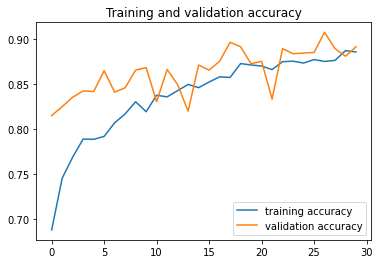

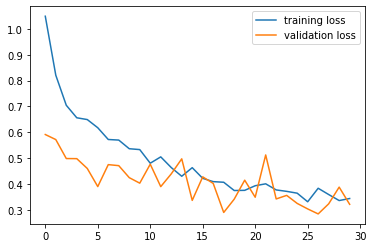

In [24]:
Score, Accuracy = model1.evaluate(X_test,y_test)
print('Validation score:', Score,'   Validation accuracy:', Accuracy)

accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs   = range(len(accuracy))

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')

D. Select a random image and print actual label and predicted label for the same.



1/1 [==============================] - 0s 146ms/step
Was predicted  2
Was labeled  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted Probabilities:  [[1.1845849e-08 1.1035935e-03 9.9887246e-01 1.1210847e-08 5.9473309e-06
  1.1799166e-05 5.0109753e-11 2.0812430e-10 5.4451375e-06 3.0272767e-07
  4.4626867e-12 4.6969458e-07]]


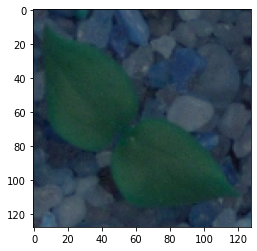

In [25]:
image_index = 50
plt.imshow(X_test[image_index].reshape(128, 128,3))
pred = model1.predict(X_test[image_index].reshape(-1, 128, 128,3))
print("Was predicted ",pred.argmax())
print("Was labeled ",y_test[image_index])
print("Predicted Probabilities: ",pred)

##**Part B**
### • DOMAIN: Botanical Research

### • CONTEXT: University X is currently undergoing some research involving understanding the characteristics of flowers. They already have invested on curating sample images. They require an automation which can create a classifier capable of determining a flower’s species from a photo.

### • DATA DESCRIPTION: The dataset comprises of images from 17 plant species.

### • PROJECT OBJECTIVE: To experiment with various approaches to train an image classifier to predict type of flower from the image.

### Steps and tasks:

Import and Understand the data.

A. Import and read oxflower17 dataset from tflearn and split into X and Y while loading.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
from tflearn.datasets import oxflower17 as oxflower17

In [12]:
X, y = oxflower17.load_data()


B. Print Number of images and shape of the images



In [14]:
print(X.shape, y.shape)


(1360, 224, 224, 3) (1360,)


C. Print count of each class from y



In [15]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))


{0: 80,
 1: 80,
 2: 80,
 3: 80,
 4: 80,
 5: 80,
 6: 80,
 7: 80,
 8: 80,
 9: 80,
 10: 80,
 11: 80,
 12: 80,
 13: 80,
 14: 80,
 15: 80,
 16: 80}

### 2. Image Exploration & Transformation
A. Display 5 random images.

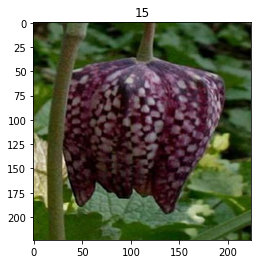

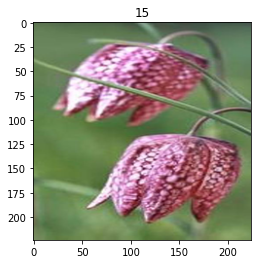

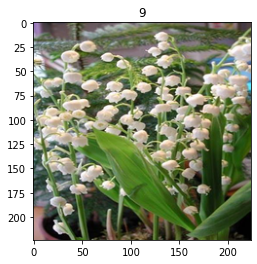

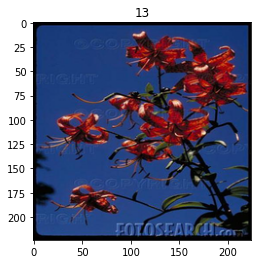

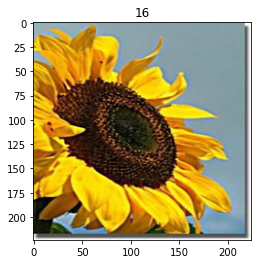

In [16]:
images = X
labels = y

def select_random_images(num_images):

  random_indices = random.sample(range(len(images)), num_images)
  
  selected_labels = [labels[i] for i in random_indices]
  
  for i in range(num_images):
    plt.imshow(images[random_indices[i]])
    plt.title(selected_labels[i])
    plt.show()

select_random_images(5)

B. Select any image from the dataset and assign it to a variable.



In [17]:
img_org = random.choice(X)


C. Transform the image into grayscale format and display the same.



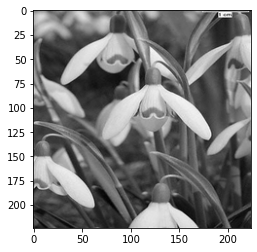

In [18]:
gray_image = cv2.cvtColor(img_org, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image,cmap='gray');

D. Apply a filter to sharpen the image and display the image before and after sharpening



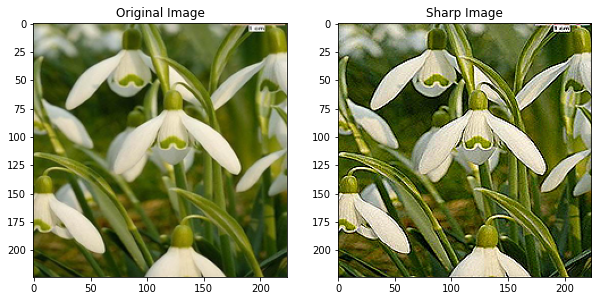

In [19]:
sharp_filter = np.array([[0,-1,0],
                        [-1,5,-1],
                        [0,-1,0]])

sharp_img = cv2.filter2D(img_org,kernel=sharp_filter,ddepth=-1)

img_title = ['Original Image', 'Sharp Image']
plt.figure(figsize=(10,10))
for i,img in enumerate([img_org, sharp_img]):
    plt.subplot(1,2,i+1)
    plt.title(img_title[i])
    plt.imshow(img,cmap='gray')

E. Apply a filter to blur the image and display the image before and after blur



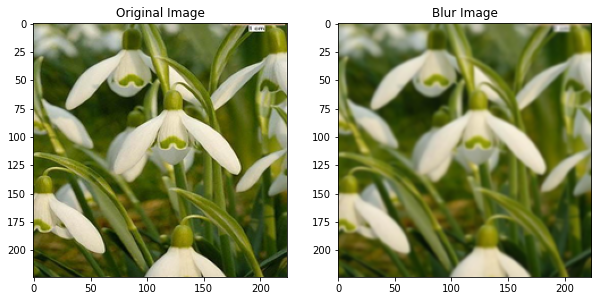

In [20]:
blur_img = cv2.GaussianBlur(img_org,ksize=(5,5),sigmaX=0,sigmaY=0)

img_title = ['Original Image', 'Blur Image']
plt.figure(figsize=(10,10))
for i,img in enumerate([img_org, blur_img]):
    plt.subplot(1,2,i+1)
    plt.title(img_title[i])
    plt.imshow(img)

F. Display all the 4 images from above questions besides each other to observe the difference.



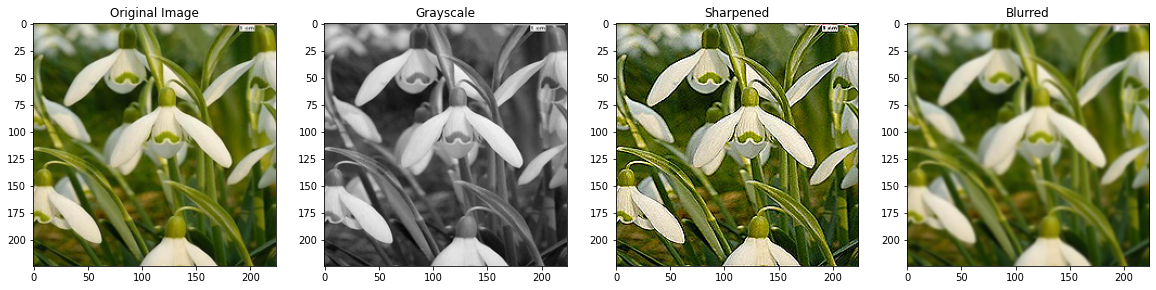

In [21]:
img_title = ['Original Image', 'Grayscale', 'Sharpened', 'Blurred']
plt.figure(figsize=(20,20))
for i,img in enumerate([img_org, gray_image, sharp_img, blur_img]):
    plt.subplot(1,4,i+1)
    plt.title(img_title[i])
    plt.imshow(img, cmap='gray')

### 3. Model training and Tuning:
A. Split the data into train and test with 80:20 proportion.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42, stratify=y)


B. Train a model using any Supervised Learning algorithm and share performance metrics on test data



In [23]:
# Reshaping the train and test data as per the SL model requirement

X_train_ML = X_train.astype('float32')
X_train_ML = X_train_ML.reshape(X_train_ML.shape[0], 150528) 
X_train_ML = X_train_ML/255

X_test_ML = X_test.astype('float32')
X_test_ML = X_test_ML.reshape(X_test_ML.shape[0], 150528)
X_test_ML = X_test_ML/255

print('Train_Shape:', X_train_ML.shape, y_train.shape)
print('Test_Shape:', X_test_ML.shape, y_test.shape)

Train_Shape: (1088, 150528) (1088,)
Test_Shape: (272, 150528) (272,)


In [24]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train_ML, y_train)

SVC()

In [25]:
svm_Accuracy=svm.score(X_train_ML, y_train)
print("Train Accuracy : ", svm_Accuracy)

svm_Accuracy=svm.score(X_test_ML, y_test)
print("Test Accuracy : ", svm_Accuracy)

Train Accuracy :  0.9264705882352942
Test Accuracy :  0.4375


C. Train a model using Neural Network and share performance metrics on test data



In [72]:
import tensorflow 
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [73]:
le = LabelEncoder()
y_train_NN = le.fit_transform(y_train)
y_test_NN = le.fit_transform(y_test)


y_train_NN = np_utils.to_categorical(y_train_NN)
y_test_NN = np_utils.to_categorical(y_test_NN)
print(y_train_NN.shape, y_test_NN.shape)

(1088, 17) (272, 17)


In [76]:
model = Sequential()  
model.add(BatchNormalization(input_shape = (150528,)))
model.add(Dense(256, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(17, activation='softmax'))

adam = optimizers.SGD(learning_rate= 0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
histroy = model.fit(X_train_ML, y_train_NN, validation_data=(X_test_ML, y_test_NN), epochs=50, verbose=1)


Train on 1088 samples, validate on 272 samples
Epoch 1/50
1056/1088 [============================>.] - ETA: 0s - loss: 3.6954 - acc: 0.0720

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1088/1088 [==============================] - 5s 4ms/sample - loss: 3.6883 - acc: 0.0708 - val_loss: 2.8303 - val_acc: 0.0588
Epoch 2/50
1088/1088 [==============================] - 1s 890us/sample - loss: 3.1579 - acc: 0.0763 - val_loss: 2.8325 - val_acc: 0.0478
Epoch 3/50
1088/1088 [==============================] - 1s 785us/sample - loss: 2.9349 - acc: 0.0855 - val_loss: 2.8321 - val_acc: 0.0772
Epoch 4/50
1088/1088 [==============================] - 1s 786us/sample - loss: 2.8595 - acc: 0.0928 - val_loss: 2.8320 - val_acc: 0.0515
Epoch 5/50
1088/1088 [==============================] - 1s 825us/sample - loss: 2.7541 - acc: 0.1250 - val_loss: 2.8331 - val_acc: 0.0588
Epoch 6/50
1088/1088 [==============================] - 1s 809us/sample - loss: 2.7286 - acc: 0.1232 - val_loss: 2.8338 - val_acc: 0.0588
Epoch 7/50
1088/1088 [==============================] - 1s 786us/sample - loss: 2.6510 - acc: 0.1287 - val_loss: 2.8322 - val_acc: 0.0662
Epoch 8/50
1088/1088 [=========================

Text(0.5, 1.0, 'Training and validation loss')

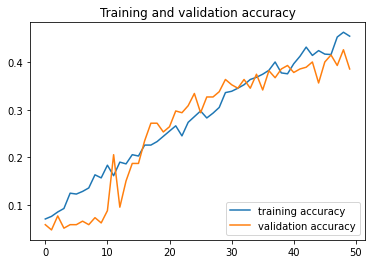

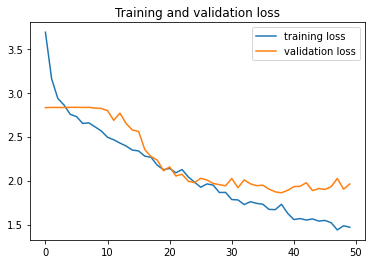

In [78]:
accuracy      = histroy.history['acc']
val_accuracy  = histroy.history['val_acc']
loss     = histroy.history['loss']
val_loss = histroy.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

In [79]:
Score, Accuracy = model.evaluate(X_test_ML,y_test_NN)
print('Validation score:', Score,'   Validation accuracy:', Accuracy)

Validation score: 1.9615283573375029    Validation accuracy: 0.38602942


D. Train a model using a basic CNN and share performance metrics on test data.



In [80]:
X_train_CNN = X_train.astype('float32')
X_train_CNN = X_train_CNN.reshape(X_train_CNN.shape[0], 224, 224, 3) 
X_train_CNN = X_train_CNN/255

X_test_CNN = X_test.astype('float32')
X_test_CNN = X_test_CNN.reshape(X_test_CNN.shape[0], 224, 224, 3)
X_test_CNN = X_test_CNN/255

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D

model_1 = Sequential()

model_1.add(BatchNormalization(input_shape = (224, 224, 3)))

model_1.add(Convolution2D(filters = 32, kernel_size = 3, activation ='relu', input_shape = (224, 224, 3))) 
model_1.add(MaxPooling2D(pool_size = 2))

model_1.add(Convolution2D(filters = 64, kernel_size = 3, activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = 2))

model_1.add(Convolution2D(filters = 128, kernel_size = 3, activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = 2))

model_1.add(Flatten()) 


model_1.add(Dense(units = 128,activation = 'relu'))
model_1.add(Dense(units = 64, activation = 'relu'))
model_1.add(Dense(units = 32, activation = 'relu'))

model_1.add(Dense(units = 17, activation = 'softmax'))

opt = optimizers.Adam(learning_rate=0.0001)
model_1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_1.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_20 (Bat  (None, 224, 224, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                     

In [96]:
history1 = model_1.fit(X_train_CNN, y_train_NN, validation_data=(X_test_CNN, y_test_NN), epochs=50, batch_size = 8, verbose=1)


Train on 1088 samples, validate on 272 samples
Epoch 1/50
1080/1088 [============================>.] - ETA: 0s - loss: 2.5534 - acc: 0.1380

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1088/1088 [==============================] - 9s 8ms/sample - loss: 2.5507 - acc: 0.1379 - val_loss: 2.8417 - val_acc: 0.0588
Epoch 2/50
1088/1088 [==============================] - 3s 2ms/sample - loss: 2.0228 - acc: 0.2748 - val_loss: 3.3659 - val_acc: 0.0588
Epoch 3/50
1088/1088 [==============================] - 3s 2ms/sample - loss: 1.7166 - acc: 0.3529 - val_loss: 3.2061 - val_acc: 0.0588
Epoch 4/50
1088/1088 [==============================] - 3s 2ms/sample - loss: 1.4849 - acc: 0.4504 - val_loss: 2.9706 - val_acc: 0.1360
Epoch 5/50
1088/1088 [==============================] - 3s 3ms/sample - loss: 1.3472 - acc: 0.5267 - val_loss: 1.6853 - val_acc: 0.4449
Epoch 6/50
1088/1088 [==============================] - 3s 2ms/sample - loss: 1.0687 - acc: 0.6232 - val_loss: 1.6252 - val_acc: 0.4743
Epoch 7/50
1088/1088 [==============================] - 3s 2ms/sample - loss: 0.8617 - acc: 0.7004 - val_loss: 1.8275 - val_acc: 0.4338
Epoch 8/50
1088/1088 [==============================] - 3s 

Text(0.5, 1.0, 'Training and validation loss')

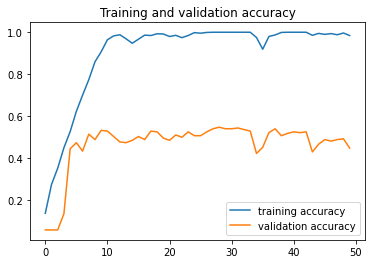

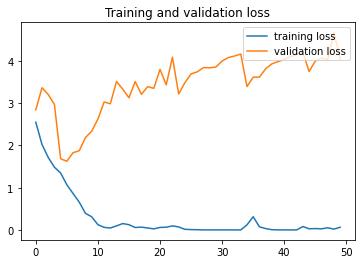

In [97]:
accuracy      = history1.history['acc']
val_accuracy  = history1.history['val_acc']
loss     = history1.history['loss']
val_loss = history1.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

The model is not converging and loss is too high for test set and low accuracy. The model is an overfit looking at the accuracy for train and test.

Using Data augmentation since the number of images in each class are too less.

In [98]:
from keras.preprocessing.image import ImageDataGenerator
datagen1 = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen1.fit(X)

In [99]:
history2 = model_1.fit_generator(datagen1.flow(X_train_CNN, y_train_NN, batch_size=8), 
                    epochs=30, validation_data=(X_test_CNN, y_test_NN))

Epoch 1/30
  1/136 [..............................] - ETA: 21s - batch: 0.0000e+00 - size: 8.0000 - loss: 5.9945 - acc: 0.2500

<ipython-input-99-486568be8827>:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model_1.fit_generator(datagen1.flow(X_train_CNN, y_train_NN, batch_size=8),


136/136 [==============================] - 13s 94ms/step - batch: 67.5000 - size: 8.0000 - loss: 2.2441 - acc: 0.3281 - val_loss: 1.6711 - val_acc: 0.4412
Epoch 2/30
136/136 [==============================] - 12s 92ms/step - batch: 67.5000 - size: 8.0000 - loss: 1.7293 - acc: 0.4081 - val_loss: 1.4413 - val_acc: 0.4963
Epoch 3/30
136/136 [==============================] - 13s 93ms/step - batch: 67.5000 - size: 8.0000 - loss: 1.5669 - acc: 0.4550 - val_loss: 1.4933 - val_acc: 0.5147
Epoch 4/30
136/136 [==============================] - 13s 93ms/step - batch: 67.5000 - size: 8.0000 - loss: 1.4686 - acc: 0.4770 - val_loss: 1.3286 - val_acc: 0.5331
Epoch 5/30
136/136 [==============================] - 13s 93ms/step - batch: 67.5000 - size: 8.0000 - loss: 1.3489 - acc: 0.5588 - val_loss: 1.3036 - val_acc: 0.5625
Epoch 6/30
136/136 [==============================] - 13s 93ms/step - batch: 67.5000 - size: 8.0000 - loss: 1.3314 - acc: 0.5340 - val_loss: 1.2578 - val_acc: 0.5404
Epoch 7/30
136/

Text(0.5, 1.0, 'Training and validation loss')

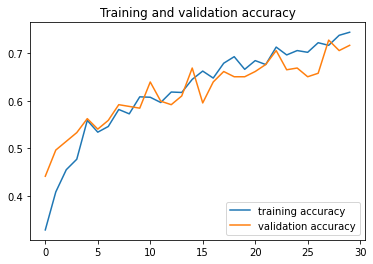

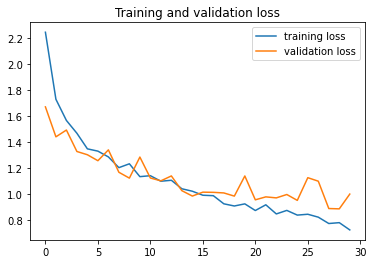

In [100]:
accuracy      = history2.history['acc']
val_accuracy  = history2.history['val_acc']
loss     = history2.history['loss']
val_loss = history2.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

In [101]:
Score, Accuracy = model_1.evaluate(X_test_CNN,y_test_NN)
print('Validation score:', Score,'   Validation accuracy:', Accuracy)

Validation score: 1.0016221123583176    Validation accuracy: 0.7169118


CNN model after augmentation is best among the 3 with highest accuracy of 71% on test data. We will predict the prediction image on this model

E. Predict the class/label of image ‘Prediction.jpg’ using best performing model and share predicted label.

Image width: 224
Image width: 224


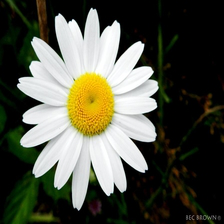

In [115]:
from PIL import Image   # pip install pillow
  
Image_name = '/content/drive/MyDrive/AIML/Prediction+-+Flower(1).jpg'
with Image.open(Image_name) as image: 
    width, height = image.size 

print("Image width:",width)    

print("Image width:",height)
    
Image.open(Image_name)

In [113]:
pred_image = cv2.imread('/content/drive/MyDrive/AIML/Prediction+-+Flower(1).jpg')
img_batch = np.expand_dims(pred_image, axis=0)

In [117]:
from tensorflow.keras.applications.resnet50 import preprocess_input

img_preprocessed = preprocess_input(img_batch)
prediction = model_1.predict(img_preprocessed)
prediction

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

The model has predicted the image as class 2. Class 2 as per below image is Daisy. The model has predicted the image correctly.



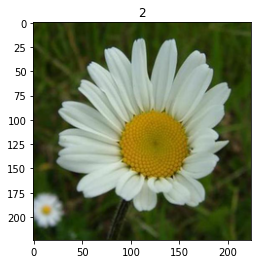

In [124]:
#Checking a random image and its label using the function already defined to see if the predicted label is correct. 
select_random_images(1)